# 10.2 A temperature-forecasting example

Throughout this chapter, all of our code examples will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the
recent past by a set of sensors on the roof of a building. As you will see, it’s a fairly challenging problem!

We’ll use this temperature-forecasting task to highlight what makes timeseries data
fundamentally different from the kinds of datasets you’ve encountered so far. You’ll see that densely connected networks and convolutional networks aren’t well-equipped
to deal with this kind of dataset, while a different kind of machine learning technique—recurrent neural networks (RNNs)—really shines on this type of problem.

We’ll work with a weather timeseries dataset recorded at the weather station at the
Max Planck Institute for Biogeochemistry in Jena, Germany.
 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)
were recorded every 10 minutes over several years. The original data goes back to
2003, but the subset of the data we’ll download is limited to 2009–2016.
 Let’s start by downloading and uncompressing the data:

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-25 02:38:42--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.123.144, 54.231.164.248, 54.231.195.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.123.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2023-07-25 02:38:43 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### Inspecting the data of the Jena weather dataset

In [2]:
import os
fname = os.path.join("/kaggle/working/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


This outputs a count of 420,451 lines of data (each line is a timestep: a record of a
date and 14 weather-related values), as well as the above header. Now, convert all 420,451 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we
will use to predict future temperatures. Note that we discard the “Date Time” column.

### Parsing the data

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    # Store column 1 in the "temperature" array.
    temperature[i] = values[1]
    # Store all columns (including the temperature) in the "raw_data" array.
    raw_data[i, :] = values[:]

The following figure shows the plot of temperature (in degree Celcius) over time. On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years.

### Plotting the temperature timeseries

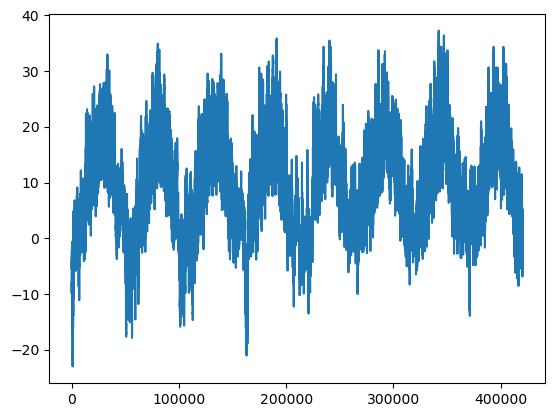

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

The next figure shows a more narrow plot of the first 10 days of temperature data. Because
the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day.

### Plotting the first 10 days of the temperature timeseries

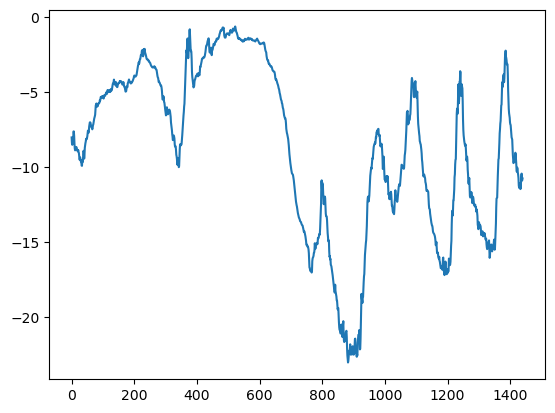

In [5]:
plt.plot(range(1440), temperature[:1440])

On this plot, you can see daily periodicity, especially for the last 4 days. Also note that
this 10-day period must be coming from a fairly cold winter month.

<div class="alert alert-block alert-info">
<b>Always look for periodicity in your data</b>
    
Periodicity over multiple timescales is an important and very common property of
timeseries data. Whether you’re looking at the weather, mall parking occupancy, traffic to a website, sales of a grocery store, or steps logged in a fitness tracker, you’ll
see daily cycles and yearly cycles (human-generated data also tends to feature
weekly cycles). When exploring your data, make sure to look for these patterns.
</div>

With our dataset, if you were trying to predict average temperature for the next month
given a few months of past data, the problem would be easy, due to the reliable yearscale periodicity of the data. But looking at the data over a scale of days, the temperature
looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries
data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse,
and your validation/test splits should reflect that. Some problems happen to be considerably simpler if you reverse the time axis!

### Computing the number of samples we’ll use for each data split

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## 10.2.1 Preparing the data

The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

 First, let’s preprocess the data to a format a neural network can ingest. This is
easy: the data is already numerical, so you don’t need to do any vectorization. But
each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per
mole, is around 3). We’ll normalize each timeseries independently so that they all
take small values on a similar scale. We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

### Normalizing the data

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Next, let’s create a `Dataset` object that yields batches of data from the past five days
along with a target temperature 24 hours in the future. Because the samples in the
dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample.
Instead, we’ll generate the samples on the fly while only keeping in memory the original `raw_data` and `temperature` arrays, and nothing more.

 We could easily write a Python generator to do this, but there’s a built-in dataset
utility in Keras that does just that (`timeseries_dataset_from_array()`), so we can
save ourselves some work by using it. You can generally use it for any kind of timeseries
forecasting task.

**Understanding `timeseries_dataset_from_array()`**

To understand what `timeseries_dataset_from_array()` does, let’s look at a simple example. The general idea is that you provide an array of timeseries data (the
data argument), and `timeseries_dataset_from_array()` gives you windows
extracted from the original timeseries (we’ll call them “sequences”).

For example, if you use `data = [0 1 2 3 4 5 6]` and `sequence_length=3`, then
`timeseries_dataset_from_array()` will generate the following samples: `[0 1 2],
[1 2 3], [2 3 4], [3 4 5], [4 5 6]`.

You can also pass a `targets` argument (an array) to `timeseries_dataset_from_array()`. The first entry of the `targets` array should match the desired target for the first sequence that will be generated from the data array. So if you’re
doing timeseries forecasting, `targets` should be the same array as `data`, offset
by some amount.

For instance, with `data = [0 1 2 3 4 5 6 …]` and `sequence_length=3`, you could create
a dataset to predict the next step in the series by passing `targets = [3 4 5 6 …]`. Let’s
try it:

In [10]:
import numpy as np
from tensorflow import keras

# Generate an array of sorted integers from 0 to 9.
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],        # The sequences we generate will be sampled from [0 1 2 3 4 5 6].
    targets=int_sequence[3:],      # The target for the sequence that starts at data[N] will be data[N + 3].
    sequence_length=3,             # The sequences will be 3 steps long.
    batch_size=2,                  # The sequences will be batched in batches of size 2.
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


We’ll use `timeseries_dataset_from_array()` to instantiate three datasets: one for
training, one for validation, and one for testing.

 We’ll use the following parameter values:
- `sampling_rate = 6`—Observations will be sampled at one data point per hour:
we will only keep one data point out of 6.
- `sequence_length = 120`—Observations will go back 5 days (120 hours).
- `delay = sampling_rate * (sequence_length - 1 + 24)`—The target for a sequence
will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass `start_index = 0` and `end_index = num_train_samples` to only use the first 50% of the data. For the validation dataset,
we’ll pass `start_index = num_train_samples` and `end_index = num_train_samples + num_val_samples` to use the next 25% of the data. Finally, for the test dataset, we’ll pass
`start_index = num_train_samples + num_val_samples` to use the remaining samples.

### Instantiating datasets for training, validation, and testing

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length - 1 + 24)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple `(samples, targets)`, where `samples` is a batch of 256 samples, each containing 120 consecutive hours of input data, and `targets` is the corresponding array of 256 target temperatures. Note that the samples are randomly
shuffled, so two consecutive sequences in a batch (like `samples[0]` and `samples[1]`)
aren’t necessarily temporally close.

### Inspecting the output of one of our datasets

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## 10.2.2 A common-sense, non-machine learning baseline

Before we start using black-box deep learning models to solve the temperatureprediction problem, let’s try a simple, common-sense approach. It will serve as a sanity
check, and it will establish a baseline that we’ll have to beat in order to demonstrate
the usefulness of more-advanced machine learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no
known solution (yet). A classic example is that of unbalanced classification tasks,
where some classes are much more common than others. If your dataset contains 90%
instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such
a classifier is 90% accurate overall, and any learning-based approach should therefore
beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary
baselines can prove surprisingly hard to beat.

 In this case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as
well as periodical with a daily period. Thus a common-sense approach is to always
predict that the temperature 24 hours from now will be equal to the temperature
right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows: 

`np.mean(np.abs(preds - targets))`

Here’s the evaluation loop.

### Computing the common-sense baseline MAE

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
    # The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the
    # input sequence. Recall that we normalized our features, so to retrieve a temperature in degrees Celsius,
    # we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a
test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24
hours in the future will be the same as it is now, you will be off by two and a half
degrees on average. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic. Now the game is to use your knowledge of deep
learning to do better. 

## 10.2.3 Let’s try a basic machine learning model

In the same way that it’s useful to establish a common-sense baseline before trying
machine learning approaches, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and
computationally expensive models such as RNNs. This is the best way to make sure any
further complexity you throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the
data and then runs it through two `Dense` layers. Note the lack of an activation function
on the last `Dense` layer, which is typical for a regression problem. We use mean
squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth
around zero, which is a useful property for gradient descent. We will monitor MAE by
adding it as a metric in `compile()`.

### Training and evaluating a densely connected model

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, 
                    epochs=10, 
                    validation_data=val_dataset, 
                    callbacks=callbacks)

model = keras.models.load_model("/kaggle/working/jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 31ms/step - loss: 12.3486 - mae: 2.7191 - val_loss: 10.9742 - val_mae: 2.6124
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 8.9837 - mae: 2.3551 - val_loss: 10.6034 - val_mae: 2.5690
Epoch 3/10
819/819 [==============================] - 25s 30ms/step - loss: 8.2433 - mae: 2.2576 - val_loss: 10.9636 - val_mae: 2.6095
Epoch 4/10
819/819 [==============================] - 27s 32ms/step - loss: 7.7987 - mae: 2.1970 - val_loss: 10.4148 - val_mae: 2.5395
Epoch 5/10
819/819 [==============================] - 23s 28ms/step - loss: 7.4815 - mae: 2.1545 - val_loss: 10.4717 - val_mae: 2.5357
Epoch 6/10
819/819 [==============================] - 26s 32ms/step - loss: 7.2425 - mae: 2.1227 - val_loss: 11.3390 - val_mae: 2.6451
Epoch 7/10
819/819 [==============================] - 27s 32ms/step - loss: 7.0523 - mae: 2.0928 - val_loss: 12.4711 - val_mae: 2.7760
Epoch 8/10
819/819 [==============================] - 

### Plotting results

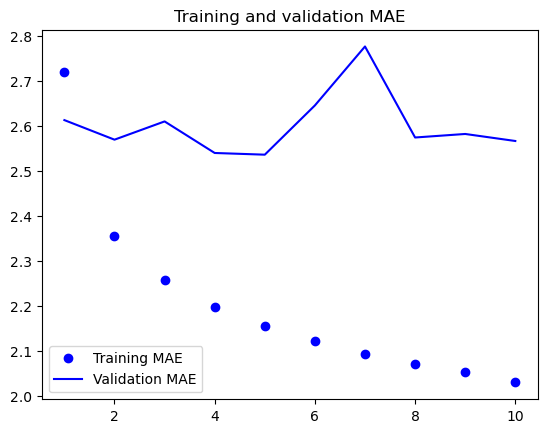

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably.
This goes to show the merit of having this baseline in the first place: it turns out to be
not easy to outperform. Your common sense contains a lot of valuable information to
which a machine learning model doesn’t have access.

You may wonder, if a simple, well-performing model exists to go from the data to
the targets (the common-sense baseline), why doesn’t the model you’re training find it
and improve on it? Well, the space of models in which you’re searching for a solution—
that is, your hypothesis space—is the space of all possible two-layer networks with the
configuration you defined. The common-sense heuristic is just one model among millions that can be represented in this space. It’s like looking for a needle in a haystack.
Just because a good solution technically exists in your hypothesis space doesn’t mean
you’ll be able to find it via gradient descent.

That’s a pretty significant limitation of machine learning in general: unless the
learning algorithm is hardcoded to look for a specific kind of simple model, it can
sometimes fail to find a simple solution to a simple problem. That’s why leveraging
good feature engineering and relevant architecture priors is essential: you need to
precisely tell your model what it should be looking for. 

## 10.2.4 Let’s try a 1D convolutional model

Speaking of leveraging the right architecture priors, since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet
could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

You already know about the `Conv2D` and `SeparableConv2D` layers, which see their
inputs through small windows that swipe across 2D grids. There are also 1D and even 3D versions of these layers: `Conv1D`, `SeparableConv1D`, and `Conv3D`. The `Conv1D` layer relies on 1D windows that slide across input sequences, and the `Conv3D` layer relies on
cubic windows that slide across input volumes.

 You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great
fit for any sequence data that follows the translation invariance assumption (meaning
that if you slide a window over the sequence, the content of the window should follow
the same properties independently of the location of the window).

 Let’s try one on our temperature-forecasting problem. We’ll pick an initial window
length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via `MaxPooling1D` layers), we’ll reduce the window size accordingly:

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
model = keras.models.load_model("/kaggle/working/jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 33s 40ms/step - loss: 22.8296 - mae: 3.7093 - val_loss: 17.2833 - val_mae: 3.2661
Epoch 2/10
819/819 [==============================] - 33s 40ms/step - loss: 15.4510 - mae: 3.1207 - val_loss: 16.4465 - val_mae: 3.1799
Epoch 3/10
819/819 [==============================] - 32s 39ms/step - loss: 14.3810 - mae: 3.0096 - val_loss: 22.5544 - val_mae: 3.8655
Epoch 4/10
819/819 [==============================] - 32s 39ms/step - loss: 13.5819 - mae: 2.9205 - val_loss: 14.8335 - val_mae: 3.0141
Epoch 5/10
819/819 [==============================] - 31s 38ms/step - loss: 12.9270 - mae: 2.8511 - val_loss: 14.8812 - val_mae: 3.0171
Epoch 6/10
819/819 [==============================] - 32s 39ms/step - loss: 12.4125 - mae: 2.7896 - val_loss: 14.5026 - val_mae: 2.9778
Epoch 7/10
819/819 [==============================] - 33s 41ms/step - loss: 11.9570 - mae: 2.7342 - val_loss: 15.7263 - val_mae: 3.0662
Epoch 8/10
819/819 [============================

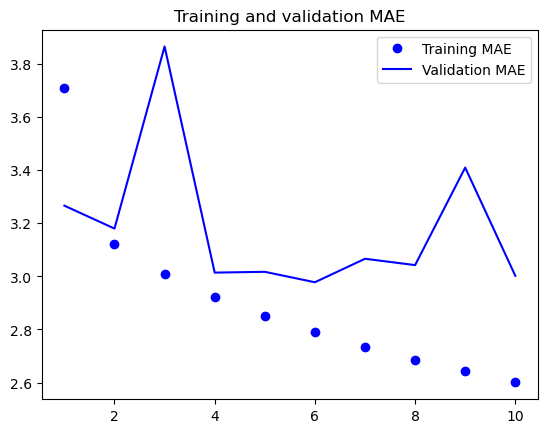

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We get the training and validation curves shown in figure 10.4.
 As it turns out, this model performs even worse than the densely connected one,
only achieving a validation MAE of about 3.0 degrees, far from the common-sense
baseline. What went wrong here? Two things:
- First, weather data doesn’t quite respect the translation invariance assumption.
While the data does feature daily cycles, data from a morning follows different
properties than data from an evening or from the middle of the night. Weather
data is only translation-invariant for a very specific timescale.
- Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A
1D convnet is not able to leverage this fact. In particular, our max pooling and
global average pooling layers are largely destroying order information. 

## 10.2.5 A first recurrent baseline

Neither the fully connected approach nor the convolutional approach did well, but
that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time
from the input data. The convolutional approach treated every segment of the data in
the same way, even applying pooling, which destroyed order information. Let’s
instead look at the data as what it is: a sequence, where causality and order matter.

There’s a family of neural network architectures designed specifically for this use
case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM)
layer has long been very popular. We’ll see in a minute how these models work, but
let’s start by giving the LSTM layer a try.

### A simple LSTM-based model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("/kaggle/working/jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 62ms/step - loss: 40.7055 - mae: 4.6403 - val_loss: 12.4618 - val_mae: 2.6823
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 10.9210 - mae: 2.5750 - val_loss: 9.8078 - val_mae: 2.4382
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 9.7662 - mae: 2.4389 - val_loss: 9.6628 - val_mae: 2.4059
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 9.3032 - mae: 2.3846 - val_loss: 9.6810 - val_mae: 2.3934
Epoch 5/10
819/819 [==============================] - 53s 64ms/step - loss: 8.9794 - mae: 2.3471 - val_loss: 9.6253 - val_mae: 2.3978
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 8.7628 - mae: 2.3160 - val_loss: 9.6802 - val_mae: 2.3971
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 8.5421 - mae: 2.2868 - val_loss: 9.8406 - val_mae: 2.4207
Epoch 8/10
819/819 [==============================] - 55s 6

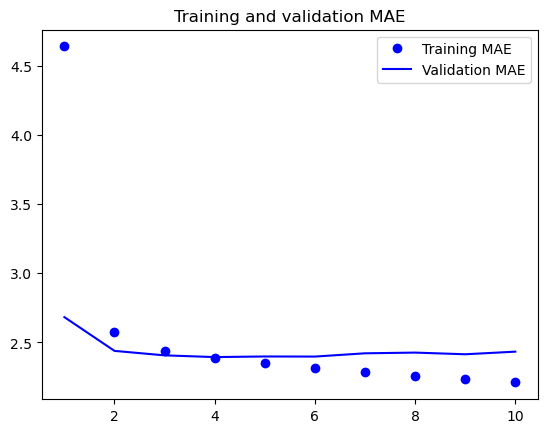

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

 Much better! We achieve a validation MAE as low as 2.36
degrees and a test MAE of 2.53 degrees. The LSTM-based model can finally beat the
common-sense baseline (albeit just by a bit, for now), demonstrating the value of
machine learning on this task.

# 10.4 Advanced use of recurrent neural networks

Next, we’ll review a number of more advanced features of RNNs, which can help you
get the most out of your deep learning sequence models. By the end of the section,
you’ll know most of what there is to know about using recurrent networks with Keras.
 We’ll cover the following:
- *Recurrent dropout*—This is a variant of dropout, used to fight overfitting in recurrent layers.
- *Stacking recurrent layers*—This increases the representational power of the model
(at the cost of higher computational loads).
- *Bidirectional recurrent layers*—These present the same information to a recurrent
network in different ways, increasing accuracy and mitigating forgetting issues.

We’ll use these techniques to refine our temperature-forecasting RNN.

Let’s go back to the LSTM-based model we used in section 10.2.5—our first model
able to beat the common-sense baseline. If you look at the training and validation
curves (figure 10.5), it’s evident that the model is quickly overfitting, despite only having very few units: the training and validation losses start to diverge considerably after
a few epochs. You’re already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question.

 It has long been known that applying dropout before a recurrent layer hinders
learning rather than helping with regularization. In 2016, Yarin Gal, as part of his PhD
thesis on Bayesian deep learning (Yarin Gal, “Uncertainty in Deep Learning,” PhD thesis (2016)),
 determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. What’s more, in order to regularize the representations formed by the recurrent gates of layers such as `GRU` and `LSTM`, a temporally constant dropout mask should be applied to the inner recurrent activations of the
layer (a recurrent dropout mask). Using the same dropout mask at every timestep
allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Every recurrent layer in Keras has two dropout-related
arguments: `dropout`, a float specifying the dropout rate for input units of the layer,
and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let’s add
recurrent dropout to the LSTM layer of our first LSTM example and see how doing so
impacts overfitting.

Thanks to dropout, we won’t need to rely as much on network size for regularization, so we’ll use an LSTM layer with twice as many units, which should, hopefully, be
more expressive (without dropout, this network would have started overfitting right
away—try it). Because networks being regularized with dropout always take much longer to fully converge, we’ll train the model for five times as many epochs.

### Training and evaluating a dropout-regularized LSTM

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
# To regularize the Dense layer, we also add a Dropout layer after the LSTM.
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset, 
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 98s 117ms/step - loss: 29.7821 - mae: 4.0101 - val_loss: 9.8156 - val_mae: 2.4317
Epoch 2/50
819/819 [==============================] - 99s 120ms/step - loss: 15.0381 - mae: 3.0118 - val_loss: 9.7504 - val_mae: 2.4196
Epoch 3/50
819/819 [==============================] - 100s 122ms/step - loss: 14.0731 - mae: 2.9106 - val_loss: 9.4665 - val_mae: 2.3836
Epoch 4/50
819/819 [==============================] - 101s 123ms/step - loss: 13.5715 - mae: 2.8524 - val_loss: 9.1712 - val_mae: 2.3436
Epoch 5/50
819/819 [==============================] - 100s 122ms/step - loss: 13.1789 - mae: 2.8106 - val_loss: 9.3319 - val_mae: 2.3634
Epoch 6/50
819/819 [==============================] - 101s 124ms/step - loss: 12.7506 - mae: 2.7660 - val_loss: 9.2834 - val_mae: 2.3547
Epoch 7/50
819/819 [==============================] - 100s 122ms/step - loss: 12.3894 - mae: 2.7238 - val_loss: 9.3510 - val_mae: 2.3707
Epoch 8/50
819/819 [=======================

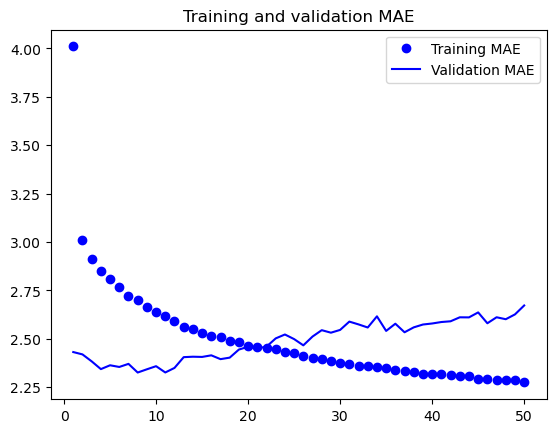

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Success! We’re no longer overfitting during the first 10
epochs. We achieve a validation MAE as low as 2.27 degrees (7% improvement over
the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the
baseline). Not too bad.

## 10.4.2 Stacking recurrent layers



In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("/kaggle/working/jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 178s 212ms/step - loss: 24.8781 - mae: 3.6826 - val_loss: 9.2413 - val_mae: 2.3576
Epoch 2/50
819/819 [==============================] - 169s 206ms/step - loss: 14.0845 - mae: 2.9055 - val_loss: 9.3076 - val_mae: 2.3735
Epoch 3/50
819/819 [==============================] - 171s 209ms/step - loss: 13.2743 - mae: 2.8185 - val_loss: 9.1547 - val_mae: 2.3508
Epoch 4/50
819/819 [==============================] - 169s 206ms/step - loss: 12.7057 - mae: 2.7583 - val_loss: 8.7285 - val_mae: 2.2990
Epoch 5/50
819/819 [==============================] - 175s 214ms/step - loss: 12.2832 - mae: 2.7143 - val_loss: 8.8494 - val_mae: 2.3195
Epoch 6/50
819/819 [==============================] - 179s 219ms/step - loss: 11.7431 - mae: 2.6567 - val_loss: 9.0119 - val_mae: 2.3398
Epoch 7/50
819/819 [==============================] - 180s 219ms/step - loss: 11.3495 - mae: 2.6121 - val_loss: 9.1327 - val_mae: 2.3672
Epoch 8/50
819/819 [=====================

### Training and evaluating a bidirectional LSTM

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 63s 73ms/step - loss: 28.2096 - mae: 3.8202 - val_loss: 10.6357 - val_mae: 2.5403
Epoch 2/10
819/819 [==============================] - 58s 71ms/step - loss: 9.6618 - mae: 2.4249 - val_loss: 9.9219 - val_mae: 2.4379
Epoch 3/10
819/819 [==============================] - 61s 74ms/step - loss: 8.7057 - mae: 2.2938 - val_loss: 9.6475 - val_mae: 2.4025
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 8.1668 - mae: 2.2155 - val_loss: 9.8877 - val_mae: 2.4535
Epoch 5/10
819/819 [==============================] - 59s 72ms/step - loss: 7.7523 - mae: 2.1576 - val_loss: 10.4090 - val_mae: 2.5084
Epoch 6/10
819/819 [==============================] - 62s 75ms/step - loss: 7.4563 - mae: 2.1149 - val_loss: 10.8998 - val_mae: 2.5752
Epoch 7/10
819/819 [==============================] - 62s 76ms/step - loss: 7.1934 - mae: 2.0785 - val_loss: 11.3188 - val_mae: 2.6258
Epoch 8/10
819/819 [==============================] - 60s